In [1]:
import smart_wsi_scanner as sws
config = sws.ConfigManager()
config.list_configs()
from pathlib import Path

# MIKE CONFIG
yaml_path = r"D:\2025QPSC\smartpath_configurations\config_PPM.yml"
# Load configuration using the config manager
ppm_settings = config.load_config_file(yaml_path)
loci_rsc_file = str(
    Path(yaml_path).parent / "resources" / "resources_LOCI.yml"
)
loci_resources = config.load_config_file(loci_rsc_file)
ppm_settings.update(loci_resources)
ppm_settings['stage']

core,studio = sws.init_pycromanager()
ppm = sws.PycromanagerHardware(core,studio,ppm_settings)

java.lang.Exception: No device with label "KBD101_Thor_Rotation"
mmcorej.MMCoreJJNI.CMMCore_getPosition__SWIG_0(Native Method)
mmcorej.CMMCore.getPosition(CMMCore.java:1236)
sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
java.lang.reflect.Method.invoke(Method.java:498)
org.micromanager.pyjavaz.ZMQServer.runMethod(ZMQServer.java:431)
org.micromanager.pyjavaz.ZMQServer.parseAndExecuteCommand(ZMQServer.java:511)
org.micromanager.pyjavaz.ZMQServer.lambda$initialize$2(ZMQServer.java:121)
java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
java.util.concurrent.FutureTask.run(FutureTask.java:266)
java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
java.lang.Thread.run(Thread.java:748)



In [18]:
from smart_wsi_scanner.swsi_autofocus_metrics import AutofocusMetrics

In [9]:
from smart_wsi_scanner.hardware import Position

In [2]:
current_pos = ppm.get_current_position()
current_pos

Position(x=15739, y=5287, z=-2880.6000000000004)

In [13]:
import numpy as np

In [24]:
z_stack = [Position( z = round(current_pos.z,2) + i)  for i in range(-29, 30,6)]
z_stack

[Position(x=None, y=None, z=-2909.6),
 Position(x=None, y=None, z=-2903.6),
 Position(x=None, y=None, z=-2897.6),
 Position(x=None, y=None, z=-2891.6),
 Position(x=None, y=None, z=-2885.6),
 Position(x=None, y=None, z=-2879.6),
 Position(x=None, y=None, z=-2873.6),
 Position(x=None, y=None, z=-2867.6),
 Position(x=None, y=None, z=-2861.6),
 Position(x=None, y=None, z=-2855.6)]

In [ ]:
# In your PycroManager autofocus routine
autofocus = AutofocusMetrics()


z_scores = []
for z_position in z_stack:
    ppm.move_to_position(z_position)
    image,tags = ppm.snap_image()
    result = autofocus.calculate_metric(image, 'tenenbaum_gradient')
    z_scores.append((z_position, result['value']))

# Find best focus
best_z = max(z_scores, key=lambda x: x[1])[0]

# Or use multi-metric for robustness
consensus = autofocus.multi_metric_analysis(image)
print(consensus)
print(z_scores)

{'metrics': {'tenenbaum_gradient': np.float64(12205232696.0), 'laplacian_variance': np.float64(2425.56646474691), 'brenner_gradient': np.float64(985343821.0)}, 'normalized_metrics': {'tenenbaum_gradient': np.float64(1.0), 'laplacian_variance': np.float64(0.0), 'brenner_gradient': np.float64(0.08073107787408713)}, 'mean_normalized': np.float64(0.3602436926246957), 'consensus_score': np.float64(0.0)}
[(Position(x=15739, y=5287, z=-2882.6), np.float64(21470785296.0)), (Position(x=15739, y=5287, z=-2881.6), np.float64(20199641578.0)), (Position(x=15739, y=5287, z=-2880.6), np.float64(17842987480.0)), (Position(x=15739, y=5287, z=-2879.6), np.float64(15272536648.0)), (Position(x=15739, y=5287, z=-2878.6), np.float64(12205232696.0))]


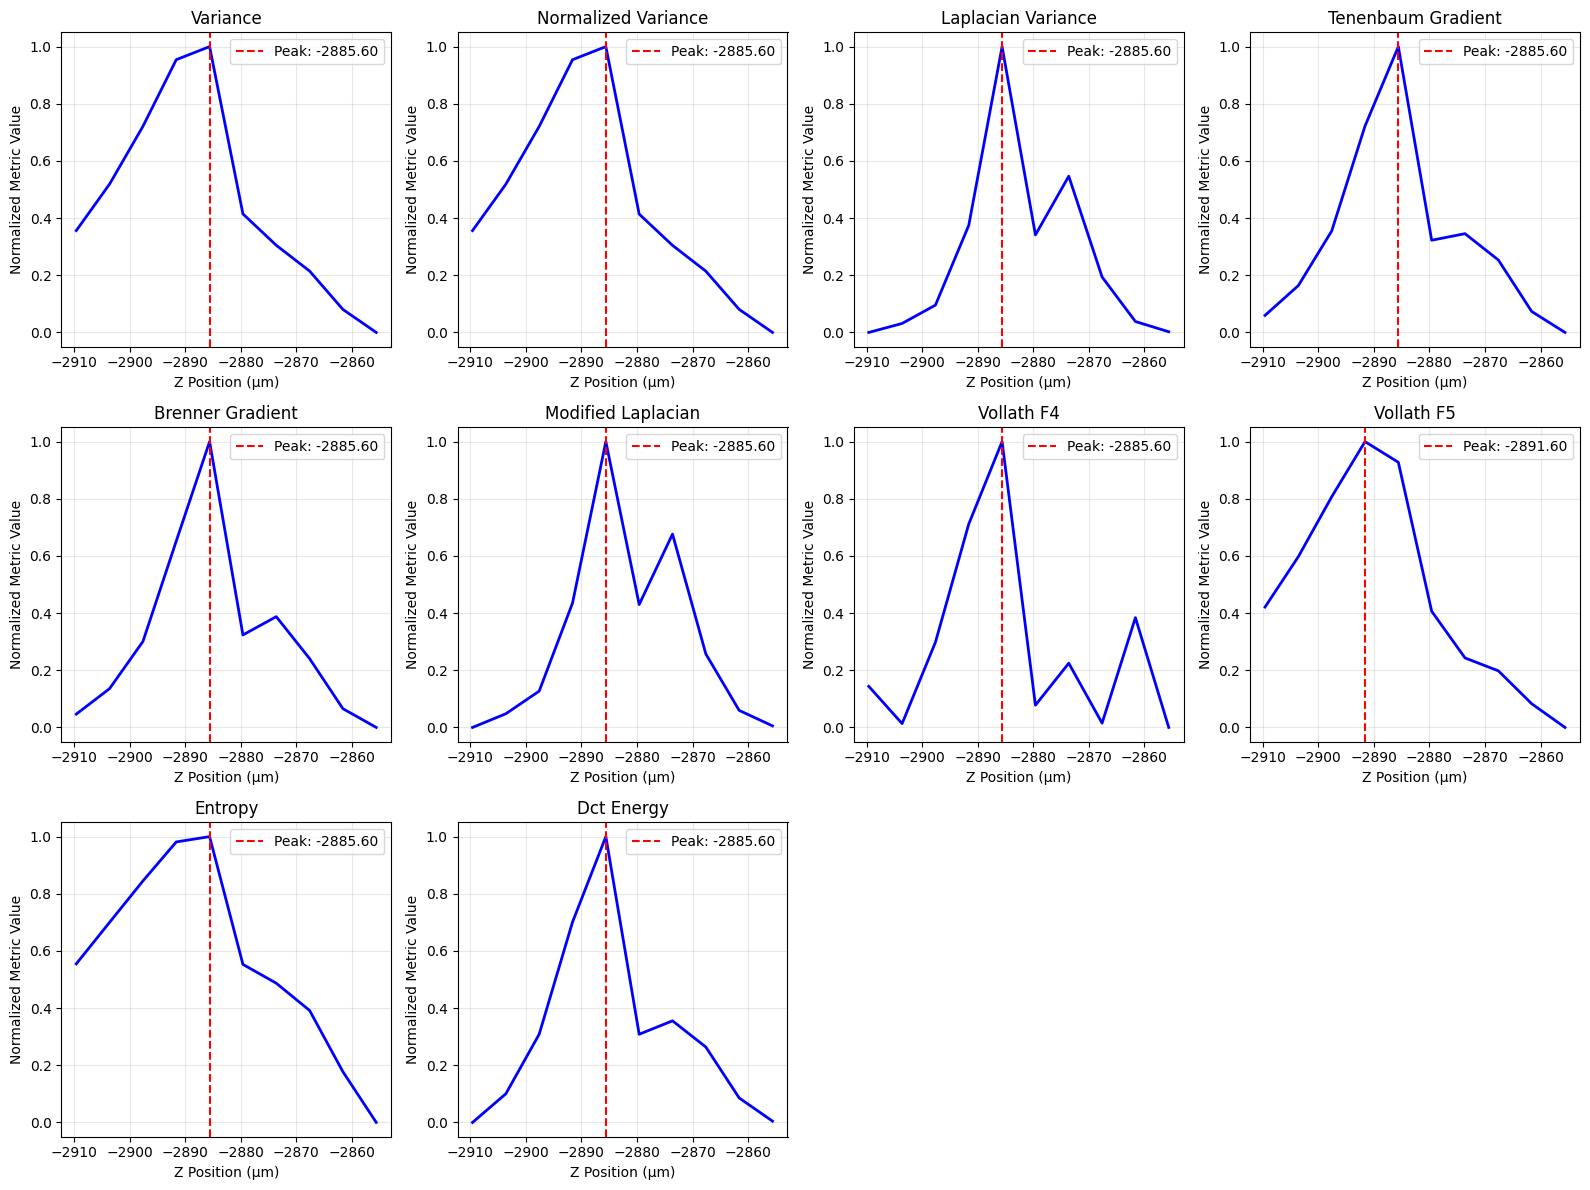


Best Z Position by Metric:
--------------------------------------------------
variance                    -2885.60 µm
normalized_variance         -2885.60 µm
laplacian_variance          -2885.60 µm
tenenbaum_gradient          -2885.60 µm
brenner_gradient            -2885.60 µm
modified_laplacian          -2885.60 µm
vollath_f4                  -2885.60 µm
vollath_f5                  -2891.60 µm
entropy                     -2885.60 µm
dct_energy                  -2885.60 µm

Consensus Z Position: -2885.60 µm
Metrics agreeing: 9/10


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# In your PycroManager autofocus routine
autofocus = AutofocusMetrics()

# Define metrics to test
metrics_to_test = [
    'variance', 'normalized_variance', 'laplacian_variance',
    'tenenbaum_gradient', 'brenner_gradient', 'modified_laplacian',
    'vollath_f4', 'vollath_f5', 'entropy', 'dct_energy'
]

# Store results for each metric
z_positions = []
metric_results = {metric: [] for metric in metrics_to_test}

# Acquire z-stack and calculate all metrics
for z_position in z_stack:
    ppm.move_to_position(z_position)
    image, tags = ppm.snap_image()
    
    z_positions.append(z_position.z)
    
    # Calculate all metrics for this z-position
    for metric in metrics_to_test:
        result = autofocus.calculate_metric(image, metric)
        metric_results[metric].append(result['value'])

# Find best focus for each metric
best_z_per_metric = {}
for metric in metrics_to_test:
    best_idx = np.argmax(metric_results[metric])
    best_z_per_metric[metric] = z_positions[best_idx]

# Plot all metrics
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_test):
    ax = axes[idx]
    
    # Normalize values to 0-1 for better visualization
    values = np.array(metric_results[metric])
    normalized = (values - values.min()) / (values.max() - values.min() + 1e-10)
    
    # Plot
    ax.plot(z_positions, normalized, 'b-', linewidth=2)
    ax.axvline(best_z_per_metric[metric], color='r', linestyle='--', 
               label=f'Peak: {best_z_per_metric[metric]:.2f}')
    ax.set_xlabel('Z Position (µm)')
    ax.set_ylabel('Normalized Metric Value')
    ax.set_title(metric.replace('_', ' ').title())
    ax.grid(True, alpha=0.3)
    ax.legend()

# Remove extra subplots
for idx in range(len(metrics_to_test), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('autofocus_metrics_comparison.png', dpi=300)
plt.show()

# Print consensus analysis
print("\nBest Z Position by Metric:")
print("-" * 50)
for metric, z_pos in best_z_per_metric.items():
    print(f"{metric:<25} {z_pos:>10.2f} µm")

# Calculate consensus (most common best Z)
z_values_list = list(best_z_per_metric.values())
consensus_z = max(set(z_values_list), key=z_values_list.count)
print(f"\nConsensus Z Position: {consensus_z:.2f} µm")
print(f"Metrics agreeing: {z_values_list.count(consensus_z)}/{len(metrics_to_test)}")

In [ ]:
# TODO : empty region implementation

In [26]:
from smart_wsi_scanner.swsi_empty_region_detection import EmptyRegionDetector

In [ ]:
detector = EmptyRegionDetector()
result = detector.detect_empty_region(image_tile, method='recommended_combo')
if result['is_empty']:
    # Good location for white balance
    perform_white_balance(x, y)